In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
%matplotlib inline
import tensorflow as tf 
import matplotlib.pyplot as plt
import numpy as np

Test example: 1/30| Predicted: 2| Actual: 2| Match: True
Predicted: 2| Actual: 1
Predicted: 2| Actual: 1
Predicted: 1| Actual: 2
Test example: 11/30| Predicted: 2| Actual: 2| Match: True
Predicted: 1| Actual: 2
Predicted: 1| Actual: 2
Predicted: 1| Actual: 0
Test example: 21/30| Predicted: 1| Actual: 0| Match: False
Predicted: 1| Actual: 2
Predicted: 2| Actual: 1
Predicted: 2| Actual: 1
21 matches out of 30 examples
Test set accuracy:  0.7


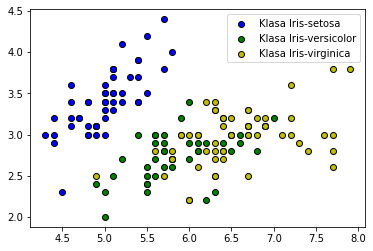

In [5]:
tf.reset_default_graph()

# KNN klasa.
class KNN:
  
  def __init__(self, nb_features, nb_classes, data, k, weighted = False):
    self.nb_features = nb_features
    self.nb_classes = nb_classes
    self.data = data
    self.k = k
    self.weight = weighted
    
    # Gradimo model, X je matrica podataka a Q je vektor koji predstavlja upit.
    self.X = tf.placeholder(shape=(None, nb_features), dtype=tf.float32)
    self.Y = tf.placeholder(shape=(None), dtype=tf.int32)
    self.Q = tf.placeholder(shape=(nb_features), dtype=tf.float32)
    
    # Racunamo kvadriranu euklidsku udaljenost i uzimamo minimalnih k.
    dists = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.X, self.Q)), 
                                  axis=1))
    _, idxs = tf.nn.top_k(-dists, self.k)  
    
    self.classes = tf.gather(self.Y, idxs)
    self.dists = tf.gather(dists, idxs)
    
    self.w = tf.fill([k], 1/k)
    
    # Svaki red mnozimo svojim glasom i sabiramo glasove po kolonama.
    w_col = tf.reshape(self.w, (k, 1))
    self.classes_one_hot = tf.one_hot(self.classes, nb_classes)
    self.scores = tf.reduce_sum(w_col * self.classes_one_hot, axis=0)
    
    # Klasa sa najvise glasova je hipoteza.
    self.hyp = tf.argmax(self.scores)
  
  # Ako imamo odgovore za upit racunamo i accuracy.
  def predict(self, query_data):
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
     
      nb_queries = query_data['x'].shape[0]
      
      matches = 0
      for i in range(nb_queries):
        hyp_val = sess.run(self.hyp, feed_dict = {self.X: self.data['x'], 
                                                  self.Y: self.data['y'], 
                                                 self.Q: query_data['x'][i]})
        if query_data['y'] is not None:
          actual = query_data['y'][i]
          match = (hyp_val == actual)
          if match:
            matches += 1
          if not match:
            print("Predicted: {}| Actual: {}".format(hyp_val, actual))
          if i % 10 == 0:
            print('Test example: {}/{}| Predicted: {}| Actual: {}| Match: {}'
                 .format(i+1, nb_queries, hyp_val, actual, match))
      
      accuracy = matches / nb_queries
      print('{} matches out of {} examples'.format(matches, nb_queries))

      # Na grafik dodajemo delove prostora koji odgovaraju klasama iz pespektive
      # naše hipoteze.
  
      # Generisemo grid.
      step_size = 0.1
      x1, x2 = np.meshgrid(np.arange(min(data['x'][:, 0]), max(data['x'][:, 0]), 
                                     step_size),
                          np.arange(min(data['x'][:, 1]), max(data['x'][:, 1]), 
                                    step_size))
      x_feed = np.vstack((x1.flatten(), x2.flatten())).T
      
      # Racunamo vrednost hipoteze.
      #pred_val = sess.run(pred, feed_dict={X: x_feed})
      #pred_plot = pred_val.reshape([x1.shape[0], x1.shape[1]])

      # Crtamo contour plot.
      from matplotlib.colors import LinearSegmentedColormap
      classes_cmap = LinearSegmentedColormap.from_list('classes_cmap', 
                                                      ['lightblue', 
                                                        'lightgreen', 
                                                        'lightyellow'])
      #plt.contourf(x1, x2, pred_plot, cmap=classes_cmap, alpha=0.7)
  
      # Crtamo sve podatke preko.
      idxs_0 = data['y'] == 0.0
      idxs_1 = data['y'] == 1.0
      idxs_2 = data['y'] == 2.0
      plt.scatter(data['x'][idxs_0, 0], data['x'][idxs_0, 1], c='b', 
                  edgecolors='k', label='Klasa Iris-setosa')
      plt.scatter(data['x'][idxs_1, 0], data['x'][idxs_1, 1], c='g', 
                  edgecolors='k', label='Klasa Iris-versicolor')
      plt.scatter(data['x'][idxs_2, 0], data['x'][idxs_2, 1], c='y', 
                  edgecolors='k', label='Klasa Iris-virginica')
      plt.legend()
      return accuracy

# Učitavanje i obrada podataka.
filename = 'iris.csv'
all_data = np.loadtxt(filename, delimiter=',', skiprows=1, usecols=(0, 1))
classes_str = np.loadtxt(filename, delimiter=',', dtype=np.str, skiprows=1, usecols=(4))

def class_string_to_int(class_string):
  if class_string == 'Iris-setosa':
    return 0
  elif class_string == 'Iris-versicolor':
    return 1
  elif class_string == 'Iris-virginica':
    return 2

classes_int = list(map(class_string_to_int, classes_str))
classes_int = np.array(classes_int)

data = dict()
data['x'] = all_data[:, :2]
data['y'] = classes_int

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

# Deljenje na trening deo i test deo.
train_ratio = 0.8

nb_train = int(train_ratio * nb_samples)
data_train = dict()
data_train['x'] = data['x'][:nb_train]
data_train['y'] = data['y'][:nb_train]

nb_test = nb_samples - nb_train
data_test = dict()
data_test['x'] = data['x'][nb_train:]
data_test['y'] = data['y'][nb_train:]

nb_features = 2
nb_classes = 3
k = 3

train_data = {'x': data_train['x'], 'y': data_train['y']}
knn = KNN(nb_features, nb_classes, train_data, k, weighted = False)
accuracy = knn.predict({'x': data_test['x'], 'y': data_test['y']})
print('Test set accuracy: ', accuracy)

